In [ ]:
using JPEC, Plots
# test

In [ ]:
struct equil_settings
    grid_type::String
    mpsi::Int
    psilow::Float64
    psihigh::Float64
end

mutable struct equil_bdata
    psi::Float64
    psir::Float64
    psiz::Float64
    psirz::Float64
    psirr::Float64
    psizz::Float64
    f::Float64
    f1::Float64
    p::Float64
    p1::Float64
    br::Float64
    bz::Float64
    brr::Float64
    brz::Float64
    bzr::Float64
    bzz::Float64
end

function bfield_eval(bdata::equil_bdata, psi_in::JPEC.SplinesMod.BicubicSplineType, sq_in::JPEC.SplinesMod.CubicSplineType, r::Float64, z::Float64, psio::Float64)
    # Equivalent of direct_mod.direct_get_bfield from fortran version
    f, fr, fz, frr, frz, fzz = JPEC.SplinesMod.bicube_eval(psi_in, r, z, 2)
    bdata.psi = f[1]
    fq, fq1 = JPEC.SplinesMod.cube_eval(sq_in, 1-bdata.psi / psio, 1)
    bdata.f, bdata.f1 = fq[1], fq1[1]
    bdata.p, bdata.p1 = fq[2], fq1[2]
    bdata.psir, bdata.psiz = fr[1], fz[1]
    bdata.br, bdata.bz = bdata.psiz/r, -bdata.psir/r
    bdata.psirr, bdata.psizz = frr[1], fzz[1]
    bdata.psirz = frz[1]
    bdata.brr = (bdata.psirz - bdata.br) / r
    bdata.brz = bdata.psizz / r
    bdata.bzr = -(bdata.psirr + bdata.bz) / r
    bdata.bzz = -bdata.psirz / r
    return bdata
end

function equil_setup(eqsett::equil_settings, sq_in:: JPEC.SplinesMod.CubicSplineType, psi_in::JPEC.SplinesMod.BicubicSplineType)
    # WIP direct_mod.direct_run
    if eqsett.grid_type == "ldp"
        psixs = collect(range(0, 1, eqsett.mpsi))
        psi = eqsett.psilow .+ (eqsett.psihigh - eqsett.psilow) .* sin.(psixs .* π / 2).^2
    end
    return psi
end

equil_setup (generic function with 1 method)

In [20]:
kappa = 1.8 # elongation
a = 1.0 # minor radius
r0 = 3.5 # major radius
q0 = 1.25 # safety factor at r0
p0fac = 1.0 # >= 1
b0fac = 1.0
f0fac = 1.0

mr = 40
mz = 43
ma = 50

r = zeros(mr)
z = zeros(mz)
rg = zeros(mr,mz)
zg = zeros(mr,mz)

# psi_in = bicube(mr, mz, 1)
# sq_in = spline(ma,4)

println("equilibrium of shape: ", mr, "x", mz, " and radially resolved: ", ma)

equilibrium of shape: 40x43 and radially resolved: 50


In [21]:
ro, zo = 0., 0.
f0 = r0*b0fac
psio = kappa * f0 * a^2 / (2 * q0 * r0)
psifac = psio / (a*r0)^2
efac = 1/kappa^2
pfac = 2*psio^2*(kappa^2+1)/(a*r0*kappa)^2
rmin = r0-1.5*a
rmax = r0+1.5*a
zmin = -1.5*kappa*a
zmax = -zmin

2.7

In [ ]:
#linspace(0,1,mr)
rhos = collect(range(0, stop=1, length=ma))
psis = rhos .^2
sqfs = zeros(ma, 4)
sqfs[:, 1] .= f0*f0fac
sqfs[:, 2] .= pfac * (p0fac .- rhos)
sqfs[:, 3] .= 0
sqfs[:, 4] .= rhos

psifs = zeros(mr, mz, 1)

sq_in = GPECsplines.spline_setup(psis, sqfs, 3)
rs = collect(range(rmin, stop=rmax, length=mr))
zs = collect(range(zmin, stop=zmax, length=mz))
for i in 1:mr
    for j in 1:mz
        psifs[i, j, 1] = psio - psifac * (efac * (rs[i] * zs[j])^2 + (rs[i]^2-r0^2)^2/4)
    end
end

psi_in = GPECsplines.bicube_setup(rs, zs, psifs, 3, 3)

GPECsplines.BicubicSpline(Ptr{Nothing} @0x000000013295ac00, [2.0, 2.076923076923077, 2.1538461538461537, 2.230769230769231, 2.3076923076923075, 2.3846153846153846, 2.4615384615384617, 2.5384615384615383, 2.6153846153846154, 2.6923076923076925  …  4.3076923076923075, 4.384615384615385, 4.461538461538462, 4.538461538461538, 4.615384615384615, 4.6923076923076925, 4.769230769230769, 4.846153846153846, 4.923076923076923, 5.0], [-2.7, -2.5714285714285716, -2.442857142857143, -2.3142857142857145, -2.1857142857142855, -2.057142857142857, -1.9285714285714286, -1.8, -1.6714285714285715, -1.542857142857143  …  1.542857142857143, 1.6714285714285715, 1.8, 1.9285714285714286, 2.057142857142857, 2.1857142857142855, 2.3142857142857145, 2.442857142857143, 2.5714285714285716, 2.7], [-0.8090816326530612 -0.759902124114952 … -0.759902124114952 -0.8090816326530612; -0.775965745354197 -0.7229304469454965 … -0.7229304469454965 -0.775965745354197; … ; -4.596404005319085 -4.298416923999418 … -4.298416923999418

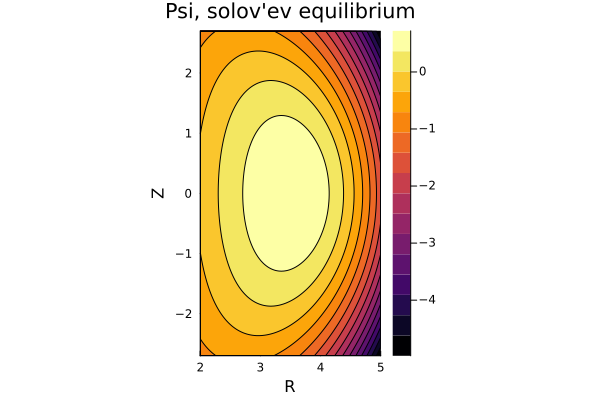

In [23]:
# Make a contour plot of the bicubic spline
xs_fine = collect(range(rmin, stop=rmax, length=110))
ys_fine = collect(range(zmin, stop=zmax, length=100))
fs_fine = GPECsplines.bicube_eval(psi_in, xs_fine, ys_fine)
# plot the bicubic spline
p1 = contourf(xs_fine, ys_fine, fs_fine[:, :, 1]', label="psi", legend=:topright)
title!("Psi, solov'ev equilibrium")
xlabel!("R")
ylabel!("Z")
# equal axis scales
plot(p1, aspect_ratio=:equal)
xlims!(rmin, rmax)
ylims!(zmin, zmax)